# ProstMorph
MRI/US fusion using VoxelMorph

In [1]:
import itertools
from pathlib import Path

import SimpleITK as sitk
import neurite as ne
import numpy as np
import tensorflow as tf
import voxelmorph as vxm

from notebooks.utils import ImageLoader

tf.div_no_nan = tf.math.divide_no_nan

### Build model
Set up the VoxelMorph network

In [9]:
def prepare_model(inshape, use_seg=True):
    if use_seg:
        vxm_model = vxm.networks.VxmDenseSemiSupervisedSeg(inshape=inshape, nb_labels=1, seg_downsize=2)
    else:
        vxm_model = vxm.networks.VxmDense(inshape=inshape)

    # histogram bins
    bin_centers = np.linspace(0, 1, 48)  # assume normalized images

    # assigning loss
    lambda_param = 0.05
    gamma_param = 0.01
    loss_weights = [1, lambda_param] \
                    + [gamma_param] if use_seg else []

    losses = [vxm.losses.NMI(bin_centers=bin_centers, vol_size=inshape, local=False).loss, vxm.losses.Grad('l2').loss] \
                    + [vxm.losses.Dice().loss] if use_seg else []

    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=losses, loss_weights=loss_weights)
    return vxm_model

class SmartDataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""
    def __init__(self, data_paths, dim, batch_size=32, shuffle=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.patients_cases = data_paths

        self.indexes = np.arange(len(self.patients_cases))
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.patients_cases) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        patients_list = [self.patients_cases[k] for k in indexes]

        # Generate data
        inputs, outputs = self.__data_generation(patients_list)

        return inputs, outputs

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, patients_list):
        """Generates data containing batch_size samples"""
        # X : (n_samples, *dim, n_channels)
        moving_images = np.zeros(shape=(self.batch_size, *self.dim, 1))
        fixed_images = np.zeros(shape=(self.batch_size, *self.dim, 1))
        moving_images_seg = np.zeros(shape=(self.batch_size, *self.dim, 1))
        fixed_images_seg = np.zeros(shape=(self.batch_size, *self.dim, 1))
        zero_phi = np.zeros(shape=(self.batch_size, *self.dim, len(self.dim)))

        # Generate data
        for i, data_path in enumerate(patients_list):
            mr_image_cropped, mr_prostate_cropped, us_image_cropped, us_prostate_cropped = SmartDataGenerator.single_load(data_path)
            # images need to be of the size [batch_size, H, W, D]
            moving_images[i, ..., 0] = mr_image_cropped
            fixed_images[i, ..., 0] = us_image_cropped
            moving_images_seg[i, ..., 0] = mr_prostate_cropped
            fixed_images_seg[i, ..., 0] = us_prostate_cropped
            # print(f"(loaded {data_path.name})")

        inputs = [moving_images, fixed_images, moving_images_seg]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi, fixed_images_seg]

        return inputs, outputs

    @staticmethod
    def single_load(path):
        data = np.load(path)
        mr_image, mr_prostate = data['mr_image'], data['mr_seg']
        us_image, us_prostate = data['us_image'], data['us_seg']
        return mr_image, mr_prostate, us_image, us_prostate

    @staticmethod
    def single_input(path):
        mr_image, mr_prostate, us_image, us_prostate = SmartDataGenerator.single_load(path)
        return [mr_image, us_image, mr_prostate]

Create dataset generators

In [10]:
# base_folder = Path(r"R:\DATASET_PROSTATE")
# # train_generator = DataGenerator(base_folder, batch_size=1, dim=resample_dim, resampling_spacing=(0.5, 0.5, 0.5), use_seg=True)

train_test_split = 0.95
train_val_split = 0.85

base_folder = Path(r"C:\Users\ML\Desktop\seba_preprocessed_fusion\numpy_160")
full_data = np.array(list(base_folder.iterdir()))
np.random.shuffle(full_data)
idx = (np.array([train_test_split * train_val_split, train_test_split]) * full_data.shape[0]).astype(int)
train_data, validation_data, test_data = np.split(full_data, idx)
del idx

train_generator = SmartDataGenerator(train_data, dim=(160, 160, 160), batch_size=1)
validation_generator = SmartDataGenerator(validation_data, dim=(160, 160, 160), batch_size=1)
test_generator = SmartDataGenerator(test_data, dim=(160, 160, 160), batch_size=1)

Instantiate network

In [4]:
model = prepare_model(inshape=(160, 160, 160), use_seg=True)

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


vxm info: mutual information loss is experimental


In [7]:
model.summary(line_length=160)

Model: "vxm_dense_semi_supervised_seg"
________________________________________________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape                        Param #            Connected to                                         
source_input (InputLayer)                           [(None, 160, 160, 160, 1)]          0                                                                       
________________________________________________________________________________________________________________________________________________________________
target_input (InputLayer)                           [(None, 160, 160, 160, 1)]          0                                                                       
____________________________________________________________________________________________________________________________________________________________

### Train network

In [5]:
nb_epochs = 10
steps_per_epoch = 100

In [6]:
hist = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=nb_epochs, steps_per_epoch=steps_per_epoch, initial_epoch=0,
    # use_multiprocessing=True, workers=4,
    verbose=2
)

ValueError: could not broadcast input array from shape (160,160,160) into shape (128,128,128)

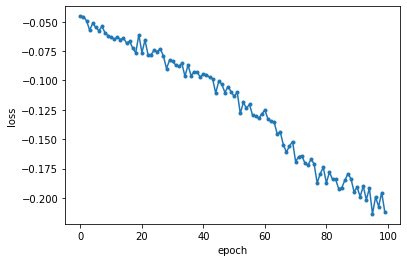

In [15]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Testing

Just load an input and watch the morphing

In [44]:
test_input, test_output = test_generator[4]
test_pred = model.predict(test_input)

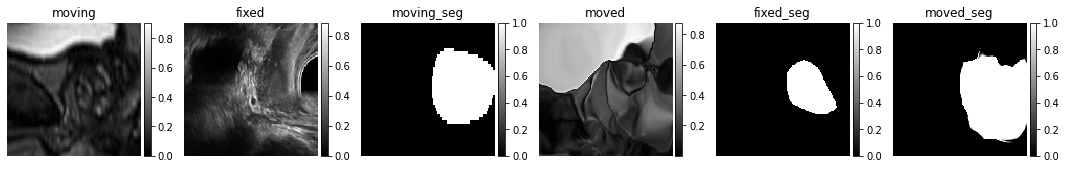

In [45]:
images = [img[0, :, :, 60].squeeze() for img in [test_input[0], test_input[1], test_input[2], test_pred[0], test_output[2], test_pred[2]]]
titles = ['moving', 'fixed', 'moving_seg', 'moved', 'fixed_seg', 'moved_seg']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

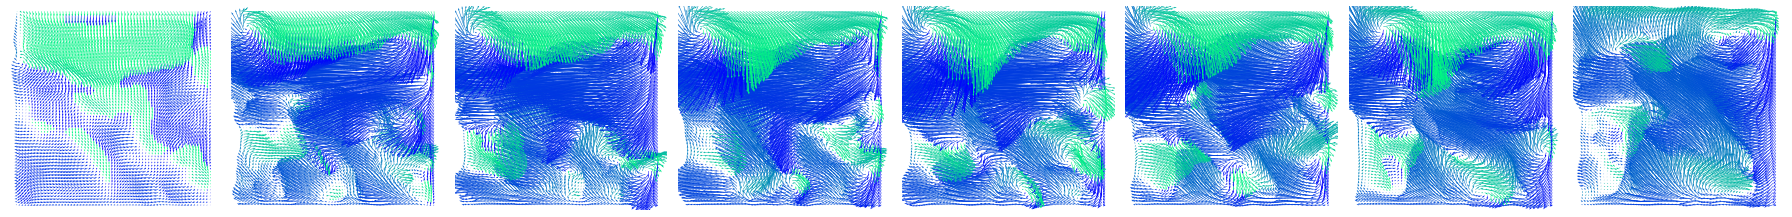

In [25]:
flow = test_pred[1].squeeze()
_ = ne.plot.flow([flow[:, :, i, [0,1]] for i in range(0, 64, 8)], width=25)